Likith Kanumuri

20039418

Assigments - HW3#


# Author: Likith Kanumuri

# Date: 11/10/2025
# Description: Goals for this homework:
1. Visualize image data
2. Preprocess image data
3. Creating a neural network
4. Training a neural network

# Step 1

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


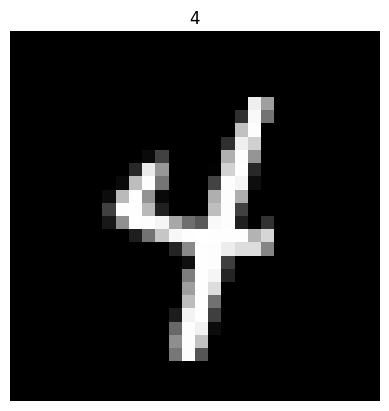

In [16]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
import math

def read_idx(filename):
  with gzip.open(filename, 'rb') as f:
    zero, data_type, dims = struct.unpack('>HBB', f.read(4))
    shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
    return np.frombuffer(f.read(), dtype = np.uint8).reshape(shape)

#Use the read_idx() function to read in each file and then print out the file's shape
Train_images = "train-images-idx3-ubyte.gz"
Train_labels = "train-labels-idx1-ubyte.gz"
Test_Images = "t10k-images-idx3-ubyte.gz"
Test_labels = "t10k-labels-idx1-ubyte.gz"

#Print out a random training image using matplotlib
x_train = read_idx(Train_images)
y_train = read_idx(Train_labels)
x_test = read_idx(Test_Images)
y_test = read_idx(Test_labels)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

rng = np.random.default_rng()
idx = rng.integers(len(x_train))
plt.imshow(x_train[idx], cmap='gray')
plt.title(str(int(y_train[idx])))
plt.axis('off')
plt.show()

# Step 2

In [17]:
#Normalize the pixel values of images to be between 0 and 1
x_train_norm = (x_train.astype(np.float32) / 255.0)
num_classes = 10
y_train_onehot = np.eye(num_classes, dtype=np.float32)[y_train]


#Convert the labels from categorical data into numerical values using one-hot encoding.
print(f"Normalized image shape: {x_train_norm.shape} {x_train_norm.dtype}")
print(f"One-hot label shape: {y_train_onehot.shape}")
example_idx = 0
print(f"Example label: {y_train[example_idx]}")
print(f"Example one-hot label: {y_train_onehot[example_idx]}")

Normalized image shape: (60000, 28, 28) float32
One-hot label shape: (60000, 10)
Example label: 5
Example one-hot label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Step 3

In [18]:
#Implement the Sigmoid function
def sigmoid(x):
    x = np.asarray(x, dtype=np.float32)
    return 1.0 / (1.0 + np.exp(-x))

#Implement Sigmoid derivative function
def sigmoid_derivative_from_x(x):
    s = sigmoid(x)
    return s * (1.0 - s)


def sigmoid_derivative_from_output(y):
    y = np.asarray(y, dtype=np.float32)
    return y * (1.0 - y)

#Implement the Softmax function
def softmax(x, axis=-1):
    x = np.asarray(x, dtype=np.float32)
    x_shift = x - np.max(x, axis=axis, keepdims=True)
    exps = np.exp(x_shift)
    return exps / np.sum(exps, axis=axis, keepdims=True)


if __name__ == "__main__":
    z = np.array([0.0, 1.0, -1.0], dtype=np.float32)
    logits = np.random.randn(5, 10).astype(np.float32)
    probs = softmax(logits)

# Step 4

In [19]:
import numpy as np

input_size  = 28 * 28
hidden_size = 128
output_size = 10

rng = np.random.default_rng(42)
W1 = rng.normal(0, 1/np.sqrt(input_size),  (input_size,  hidden_size)).astype(np.float32)
b1 = np.zeros((hidden_size,), dtype=np.float32)
W2 = rng.normal(0, 1/np.sqrt(hidden_size), (hidden_size, output_size)).astype(np.float32)
b2 = np.zeros((output_size,), dtype=np.float32)

def _flatten_images(x):
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 1:
        x = x[None, :]
    elif x.ndim == 2:
        x = x.reshape(1, -1)
    elif x.ndim == 3:
        x = x.reshape(x.shape[0], -1)
    return x



#Define feed_forward
def feed_forward(x):
  #pass
  x_flat = _flatten_images(x)
  z1 = x_flat @ W1 + b1
  a1 = sigmoid(z1)
  z2 = a1 @ W2 + b2
  y_hat = softmax(z2, axis=1)

  cache = {"x": x_flat, "z1": z1, "a1": a1, "z2": z2, "y_hat": y_hat}
  return y_hat, cache

# Step 5

In [20]:
def categorical_crossentropy(yActual, yPredicted):
  n_samples = yActual.shape[0]
  yPredictedClipped = np.clip(yPredicted, 1e-12, 1 - 1e-12)
  return -np.sum(yActual * np.log(yPredictedClipped)) / n_samples

#Define backpropogate
def backpropogate(xTrain, yTrain, yPredicted, z1, a1, z2, a2, z3, W2, W3): # Added w2,w3 also because my learning rate is getting too low.
  N = xTrain.shape[0]
  dZ3 = (yPredicted - yTrain) / N
  dW3 = a2.T @ dZ3
  db3 = np.sum(dZ3, axis=0)
  dA2 = dZ3 @ W3.T
  dZ2 = dA2 * (a2 * (1.0 - a2))
  dW2 = a1.T @ dZ2
  db2 = np.sum(dZ2, axis=0)
  dA1 = dZ2 @ W2.T
  dZ1 = dA1 * (a1 * (1.0 - a1))
  dW1 = xTrain.T @ dZ1
  db1 = np.sum(dZ1, axis=0)
  return dW1, db1, dW2, db2, dW3, db3


#Define gradientDescent
def gradientDescent(dW1, db1, dW2, db2, dW3, db3, learning_rate, W1, b1, W2, b2, W3, b3):
  W1 -= learning_rate * dW1
  b1 -= learning_rate * db1
  W2 -= learning_rate * dW2
  b2 -= learning_rate * db2
  W3 -= learning_rate * dW3
  b3 -= learning_rate * db3
  return W1, b1, W2, b2, W3, b3

# Step 6

In [21]:
# Train model using mini-batch training

import numpy as np
import gzip
import struct

D = 28 * 28
H1 = 128
H2 = 64
C  = 10

def read_idx(filename):
  with gzip.open(filename, 'rb') as f:
    zero, data_type, dims = struct.unpack('>HBB', f.read(4))
    shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
    return np.frombuffer(f.read(), dtype = np.uint8).reshape(shape)

Train_images = "train-images-idx3-ubyte.gz"
Train_labels = "train-labels-idx1-ubyte.gz"

x_train = read_idx(Train_images)
y_train = read_idx(Train_labels)

#Normalizing  the pixel values
x_train_norm = (x_train.astype(np.float32) / 255.0)
num_classes = 10
y_train_onehot = np.eye(num_classes, dtype=np.float32)[y_train]

rng = np.random.default_rng(42)
W1 = rng.normal(0, 1/np.sqrt(D), (D,  H1)).astype(np.float32); b1 = np.zeros(H1, dtype=np.float32)
W2 = rng.normal(0, 1/np.sqrt(H1),(H1, H2)).astype(np.float32); b2 = np.zeros(H2, dtype=np.float32)
W3 = rng.normal(0, 1/np.sqrt(H2),(H2,  C)).astype(np.float32); b3 = np.zeros(C,  dtype=np.float32)


def forward_2hidden(xb):
    z1 = xb @ W1 + b1
    a1 = 1.0 / (1.0 + np.exp(-z1))
    z2 = a1 @ W2 + b2
    a2 = 1.0 / (1.0 + np.exp(-z2))
    z3 = a2 @ W3 + b3
    z3_shift = z3 - np.max(z3, axis=1, keepdims=True)
    expz = np.exp(z3_shift)
    yhat = expz / np.sum(expz, axis=1, keepdims=True)
    return yhat, (z1, a1, z2, a2, z3)

# training set
X = x_train_norm.reshape(len(x_train_norm), -1).astype(np.float32)
Y = y_train_onehot.astype(np.float32)

# my_hyperparameters
epochs = 100
batch_size = 128
lr = 0.1

num_samples = X.shape[0]
num_batches = (num_samples + batch_size - 1) // batch_size

for epoch in range(1, epochs + 1):
    idx = rng.permutation(num_samples)
    X = X[idx]
    Y = Y[idx]

    epoch_loss_sum = 0.0

    for b in range(num_batches):
        s = b * batch_size
        e = min(s + batch_size, num_samples)
        xb = X[s:e]
        yb = Y[s:e]

        # forward
        yhat, (z1, a1, z2, a2, z3) = forward_2hidden(xb)

        # loss
        batch_loss = categorical_crossentropy(yb, yhat)
        epoch_loss_sum += batch_loss * (e - s)

        # backprop & gradient descent
        dW1, db1, dW2, db2, dW3, db3 = backpropogate(xb, yb, yhat, z1, a1, z2, a2, z3, W2, W3)
        W1, b1, W2, b2, W3, b3 = gradientDescent(dW1, db1, dW2, db2, dW3, db3, lr, W1, b1, W2, b2, W3, b3)


    epoch_loss = epoch_loss_sum / num_samples
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch}/100, Loss: {epoch_loss:.4f}")

Epoch 1/100, Loss: 2.0013
Epoch 10/100, Loss: 0.2817
Epoch 20/100, Loss: 0.1913
Epoch 30/100, Loss: 0.1408
Epoch 40/100, Loss: 0.1088
Epoch 50/100, Loss: 0.0871
Epoch 60/100, Loss: 0.0713
Epoch 70/100, Loss: 0.0591
Epoch 80/100, Loss: 0.0494
Epoch 90/100, Loss: 0.0416
Epoch 100/100, Loss: 0.0350


# Step 7

Test Accuracy: 94.8000


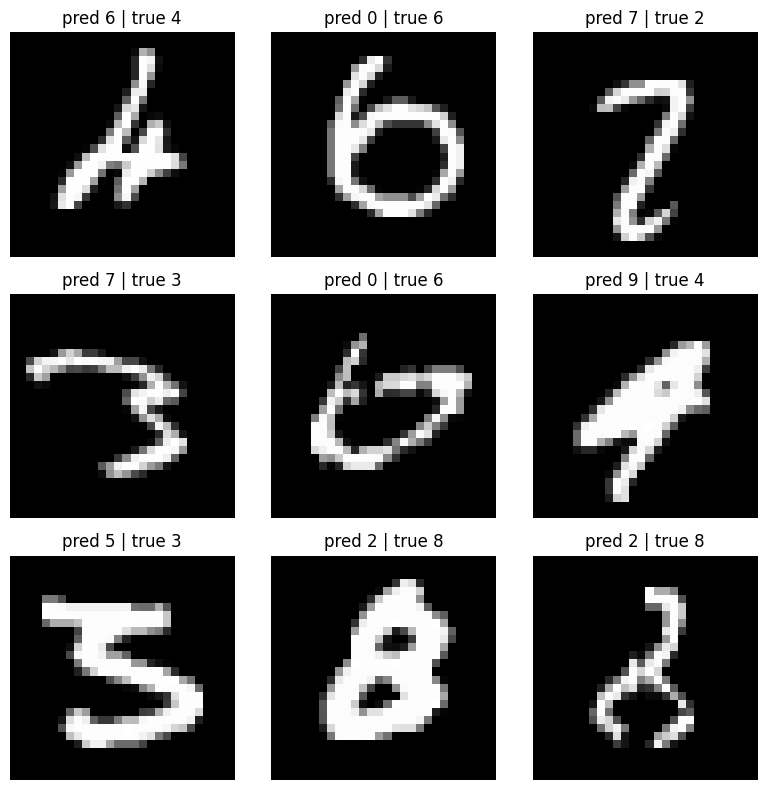

In [28]:
# Run testing data through forward pass to generate predictions
x_test_norm = (x_test.astype(np.float32) / 255.0)


D = 28 * 28
H1 = 128
H2 = 64
C  = 10


def forward_batch(xb):
    z1 = xb @ W1 + b1
    a1 = 1.0 / (1.0 + np.exp(-z1))
    z2 = a1 @ W2 + b2
    a2 = 1.0 / (1.0 + np.exp(-z2))
    z3 = a2 @ W3 + b3
    z3_shift = z3 - np.max(z3, axis=1, keepdims=True)
    expz = np.exp(z3_shift)
    yhat = expz / np.sum(expz, axis=1, keepdims=True)
    return yhat, (z1, a1, z2, a2, z3)


xt = x_test_norm.reshape(x_test_norm.shape[0], -1).astype(np.float32)
probs, _ = forward_batch(xt)
y_pred = np.argmax(probs, axis=1)
y_true = y_test.astype(int)

# Accuracy
acc = np.mean(y_pred == y_true)
print(f"Test Accuracy: {acc*100:.4f}")

# Plotting for first 9 misclassified
import matplotlib.pyplot as plt
num_to_show = min(9, len(mis_idx))
if num_to_show == 0:
    print("No misclassifications")
else:
    plt.figure(figsize=(8, 8))
    for i in range(num_to_show):
        idx = mis_idx[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(x_test_norm[idx], cmap='gray')
        plt.title(f"pred {y_pred[idx]} | true {y_true[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
